In [ ]:
# !conda env list
# This script is not used anymore. 

In [2]:
# %pip install xmltodict
# %pip install isodate
# %pip install pandas
# %pip install --no-cache-dir --force-reinstall numpy
# %pip install --upgrade scipy pandas
# %pip install lm-format-enforcer
# %pip install pandas

In [50]:
import xmltodict, json
import os
import pandas as pd
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
from itertools import combinations
import json, re

### Load raw dataset

In [51]:
# !pwd
# !conda env list
# !python --version
# !cd /home/jovyan/work/Temporal_relation/
# !pwd

In [52]:
# Change to path to the data
# path = '/home/wt/Downloads/n2c2 2012/'
wp = '/home/jovyan/work/Temporal_relation/'
path = wp + 'data/i2b2/'
training_data_path = path + 'merge_training'
test_data_path = path + 'ground_truth/merged_xml'

In [53]:
def data_loader(data_path):
    data = {}
    for filename in os.listdir(data_path):
        if filename.endswith(".xml"): 
            f = (os.path.join(data_path, filename))
#             print(f)
            fb = open(f, "rb").read().decode(encoding="utf-8")
#     invalid character '&' https://github.com/martinblech/xmltodict/issues/277
            fb = fb.replace('&', '&amp;')
            dic = xmltodict.parse(fb, attr_prefix='')
#     restore orginal character "&"
            dic['ClinicalNarrativeTemporalAnnotation']['TEXT'] = dic['ClinicalNarrativeTemporalAnnotation']['TEXT'].replace('&amp;', '&')
            data[filename] = (dic)
    return data

In [54]:
train_data = data_loader(training_data_path)
test_data = data_loader(test_data_path)

In [55]:
print(len(train_data), len(test_data))

190 120


In [56]:
# from dateutil.relativedelta import relativedelta
# import isodate
# from datetime import datetime

# anchor_date = datetime(2002, 2, 1)  # example from TIMEX3 id T0

# # Example: Convert "P3Y" to a relativedelta
# duration_str = "P3Y"
# delta = isodate.parse_duration(duration_str)  # delta will be a timedelta or duration object
# # For years/months, use: 
# rd = relativedelta(years=3)  # if P3Y specifically means 3 years

# # Now, combine with the anchor date:
# resolved_date = anchor_date + rd
# print(resolved_date)  # 2005-02-01

In [57]:
def find_first_regex(text, substrings):
    pattern = '|'.join(map(re.escape, substrings))  # Escape special characters
    match = re.search(pattern, text)
    if match:
        return match.start()
    else:
        raise ValueError("None of the substrings found in the text.")

In [58]:
data = {
    'text': ['happy event', 'bad experience', 'joyful moment', 'terrible incident'],
    'polarity': ['POS', 'NEG', 'POS', 'NEG']
}
events = pd.DataFrame(data)

# Prepend "no " to the "text" column for rows where polarity is 'NEG'
events.loc[events['polarity'] == 'NEG', 'text'] = 'no ' + events['text']

# Display the updated DataFrame
print(events)

                   text polarity
0           happy event      POS
1     no bad experience      NEG
2         joyful moment      POS
3  no terrible incident      NEG


In [59]:
def build_section_graph(doc_id, data, section='all'):
    # for doc_id in list(data.keys())[:1]:
    text = data[doc_id]['ClinicalNarrativeTemporalAnnotation']['TEXT']
    # print(text)
    
    history_start = text.index('HISTORY OF PRESENT ILLNESS ')
    substrings = ['HOSPITAL COURSE']
    history_end = find_first_regex(text, substrings)

    sect_start, sect_end = 0, len(text)
    if section == 'history':
        sect_start, sect_end = history_start, history_end
    elif section == 'other':
        sect_start, sect_end = history_end, len(text)
    # print(text[sect_start:sect_end])

    events = pd.DataFrame(data[doc_id]['ClinicalNarrativeTemporalAnnotation']['TAGS']['EVENT'])
    events['start'] = events['start'].astype(int)
    events['end'] = events['end'].astype(int)
    # Filter events in the history section
    # print('events', events.shape)
    events = events.loc[(events['start']>=sect_start) & (events['end']<=sect_end)]
    # print('events after', events.shape)
    events.loc[events['polarity'] == 'NEG', 'text'] = 'no ' + events['text']
    
    # FILTER 1: only use events related to medical concepts
    # events = events.loc[events['type'].isin(['PROBLEM', 'TEST', 'TREATMENT'])]
    event_types = dict(zip(events['id'], events['type']))
    event_values = dict(zip(events['id'], events['modality']))
    
    # Remove duplicated admission and discharge time.
    # adm_dis = pd.DataFrame(data[doc_id]['ClinicalNarrativeTemporalAnnotation']['TAGS']['SECTIME'])
    times = pd.DataFrame(data[doc_id]['ClinicalNarrativeTemporalAnnotation']['TAGS']['TIMEX3'])
    times['start'] = times['start'].astype(int)
    times['end'] = times['end'].astype(int)
    # print('times', times.shape)
    if section == 'history':
        times = times.loc[((times['start']>=sect_start) & (times['end']<=sect_end)) | (times['id']=='T0')]
    elif section == 'other':
        times = times.loc[((times['start']>=sect_start) & (times['end']<=sect_end))| (times['id']=='T1')]
    else:
        times = times.loc[((times['start']>=sect_start) & (times['end']<=sect_end))| (times['id'].isin(['T0', 'T1']))]
    # print('times after', times.shape)
    time_types = dict(zip(times['id'], times['type']))
    time_values = dict(zip(times['id'], times['val']))

    
    nodes_keep = list(events['id']) + list(times['id'])
    # print(len(nodes_keep))
    
    all_links = pd.DataFrame(data[doc_id]['ClinicalNarrativeTemporalAnnotation']['TAGS']['TLINK'])
    all_links = all_links.loc[all_links['type']!='']

    # SELECTION 1: only use events related to time expressions
    # Select key-event based on dates are not enough, as there are many events that are not related to time expressions. 
    # tlinks = all_links.loc[(all_links['fromID'].isin(time_types)) | (all_links['toID'].isin(time_types))]
    # tlinks = tlinks.loc[(tlinks['id'].str.lower().str.contains('sectime')==False)]
    # key_events = set(tlinks.loc[(tlinks['fromID'].isin(event_types))]['fromID'].unique()) | set(tlinks.loc[(tlinks['toID'].isin(event_types))]['toID'].unique())
    # print(len(key_events))

    
    # FILTER 2: Exclude sectime links not about admission/disharge
    if section == 'history':
        links = all_links.loc[(all_links['id'].str.lower().str.contains('sectime')==False) | ((all_links['id'].str.lower().str.contains('sectime')==True) & (all_links['toID']=='T0'))]
    elif section == 'other':
        links = all_links.loc[(all_links['id'].str.lower().str.contains('sectime')==False) | ((all_links['id'].str.lower().str.contains('sectime')==True) & (all_links['toID']=='T1'))]
    else:
        links = all_links
    
    
    # Normalize AFTER and BEFORE relations
    links = links.copy()
    mask = (links['type'] == 'AFTER')
    links.loc[mask, ['fromID', 'fromText', 'toID', 'toText']] = links.loc[mask, ['toID', 'toText', 'fromID', 'fromText']].values
    links.loc[mask, 'type'] = 'BEFORE'
    links = links.drop_duplicates(subset=['fromID', 'fromText', 'toID', 'toText', 'type'], keep='last')
    
    
    G = nx.from_pandas_edgelist(links[['fromID', 'toID', 'type']], source='fromID', target='toID', edge_attr=True, create_using=nx.DiGraph())
    # source_nodes = dict(zip(links['fromID'], links['fromText']))
    # target_nodes = dict(zip(links['toID'], links['toText']))
    # nx.set_node_attributes(G, source_nodes|target_nodes, 'text')
    nx.set_node_attributes(G, dict(zip(events['id'], events['text']))|dict(zip(times['id'], times['text'])), 'text')
    nx.set_node_attributes(G, event_types|time_types, 'type')
    nx.set_node_attributes(G, event_values|time_values, 'norm_time')
    
    # only keep nodes of interest
    # FILTER 3: only subgraph
    G = G.subgraph(nodes_keep).copy()
    
    # clear reverse links and reduce redundent nodes; 
    # There are no many duplicated links
    return G, text[sect_start:sect_end]

In [61]:
# All nodes and links in the data;
# G, text = build_section_graph('36.xml', train_data, 'all')
# Only nodes and links in the history section
G, history = build_section_graph('2.xml', train_data, 'all')
# Only nodes and links in sections other than "history" section
# G, text = build_section_graph('36.xml', train_data, 'other')

In [62]:
print(f"Graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph with 177 nodes and 331 edges


In [ ]:
# len([path in nx.all_simple_paths(G, source='T2', target='E87')])


1

In [227]:
num_components = nx.number_weakly_connected_components(G)
print(f"Number of weakly connected components: {num_components}")

weakly_connected = list(nx.weakly_connected_components(G))
print(f"Component sizes: {[len(comp) for comp in weakly_connected]}")

Number of weakly connected components: 1
Component sizes: [56]


In [228]:
# nx.write_graphml(G, wp+"graphs/tem_history_graph.graphml")
# nx.write_graphml(G, wp+"graphs/tem_hospital_graph.graphml")
# nx.write_graphml(G, wp+"graphs/tem_graph_key_events_remove_sect.graphml")

### Merge overlap nodes

In [229]:
def merge_overlapping_nodes(G):
    """
    Merge nodes that are connected by edges with type='overlp'.
    Only merges edges across merged groups if they have the same direction.
    Maintains node attributes and edge attributes as JSON strings for GraphML compatibility.
    Tracks source nodes for each merged edge.
    
    Args:
        G (nx.Graph or nx.DiGraph): Input graph
        
    Returns:
        nx.Graph or nx.DiGraph: New graph with merged nodes and edges
    """
    # Create new merged graph of same type as input
    merged_G = G.__class__()
    
    # Find connected components considering only overlap edges
    overlap_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'OVERLAP']
    overlap_graph = nx.Graph()  # Undirected for finding components
    overlap_graph.add_edges_from(overlap_edges)
    
    # Get clusters of nodes to merge
    clusters = list(nx.connected_components(overlap_graph))
    
    # Create mapping from original nodes to their merged cluster names
    node_to_cluster = {}
    for cluster in clusters:
        cluster = list(cluster)
        merged_name = '+'.join(sorted(cluster))
        for node in cluster:
            node_to_cluster[node] = merged_name
    
    # Process nodes
    for cluster in clusters:
        cluster = list(cluster)
        
        if len(cluster) == 1:
            # Single node, just copy it and its attributes
            node = cluster[0]
            merged_G.add_node(node, **G.nodes[node])
            continue
            
        # Create merged node name
        merged_node = '+'.join(sorted(cluster))
        
        # Combine node attributes and convert to JSON string
        merged_attrs = {
            'original_nodes': json.dumps(cluster),
            'node_attributes': json.dumps({node: dict(G.nodes[node]) for node in cluster})
        }
        
        # Add merged node
        merged_G.add_node(merged_node, **merged_attrs)
    
    # Add nodes that weren't in any cluster
    unclustered_nodes = set(G.nodes()) - set(node for cluster in clusters for node in cluster)
    for node in unclustered_nodes:
        merged_G.add_node(node, **G.nodes[node])
        node_to_cluster[node] = node  # Map to itself
    
    # Create a dictionary to store edges between clusters
    cluster_edges = {}  # (from_cluster, to_cluster) -> list of original edges with source info
    
    # Process edges
    for u, v, data in G.edges(data=True):
        # Get cluster names (or original names for unclustered nodes)
        u_cluster = node_to_cluster[u]
        v_cluster = node_to_cluster[v]
        
        # Skip internal edges of merged clusters if they were overlap edges
        if u_cluster == v_cluster and data.get('type') == 'OVERLAP':
            continue
        
        # Add source node information to edge data
        edge_data = data.copy()
        edge_data['source_nodes'] = {'from': u, 'to': v}
        
        # Create edge key based on direction
        edge_key = (u_cluster, v_cluster)
        
        # For directed graphs, maintain direction information
        if isinstance(G, nx.DiGraph):
            if edge_key not in cluster_edges:
                cluster_edges[edge_key] = []
            cluster_edges[edge_key].append((u, v, edge_data))
        else:
            # For undirected graphs, normalize the edge key
            normalized_key = tuple(sorted([u_cluster, v_cluster]))
            if normalized_key not in cluster_edges:
                cluster_edges[normalized_key] = []
            cluster_edges[normalized_key].append((u, v, edge_data))
    
    # Add merged edges to the graph
    for (from_cluster, to_cluster), edges in cluster_edges.items():
        # For directed graphs, check if all edges have the same direction
        if isinstance(G, nx.DiGraph):
            # Check if all edges go in the same direction
            directions = set((u_cluster, v_cluster) 
                           for u, v, _ in edges
                           for u_cluster, v_cluster in [(node_to_cluster[u], node_to_cluster[v])])
            
            if len(directions) == 1:  # All edges have same direction
                merged_G.add_edge(from_cluster, to_cluster, 
                                edge_attributes=json.dumps([data for _, _, data in edges]))
        else:
            # For undirected graphs, just add the edge
            merged_G.add_edge(from_cluster, to_cluster, 
                            edge_attributes=json.dumps([data for _, _, data in edges]))
    
    return merged_G

def load_merged_graph(graphml_file):
    """
    Load a merged graph from GraphML file and convert JSON string attributes back to Python objects.
    """
    G = nx.read_graphml(graphml_file)
    
    # Convert node attributes back from JSON
    for node in G.nodes():
        if 'original_nodes' in G.nodes[node]:
            G.nodes[node]['original_nodes'] = json.loads(G.nodes[node]['original_nodes'])
            G.nodes[node]['node_attributes'] = json.loads(G.nodes[node]['node_attributes'])
    
    # Convert edge attributes back from JSON
    for u, v in G.edges():
        if 'edge_attributes' in G[u][v]:
            G[u][v]['edge_attributes'] = json.loads(G[u][v]['edge_attributes'])
    
    return G

In [230]:
mergaed_G = merge_overlapping_nodes(G)

In [231]:
print(f"Graph with {mergaed_G.number_of_nodes()} nodes and {mergaed_G.number_of_edges()} edges")

Graph with 14 nodes and 20 edges


In [232]:
node = 'T8'
print(node, mergaed_G.nodes[node])

T8 {'text': 'the several weeks', 'type': 'DURATION', 'norm_time': 'P3W'}


In [233]:
# nx.write_graphml(mergaed_G, wp+"graphs/tem_history_graph_merge.graphml")

In [234]:
# print(list(mergaed_G.nodes(data=True)))

### Remove conflicting relations (e.g., self-link and mutual links)

In [235]:
def remove_self_links(G):
    H = G.copy()
    self_loops = list(nx.selfloop_edges(H))
    H.remove_edges_from(self_loops)
    return H

In [236]:
def remove_mutual_links(G):
    H = G.copy()
    edges_to_remove = set()
    
    for u, v in G.edges():
        if H.has_edge(v, u) and (v, u) not in edges_to_remove and (u, v) not in edges_to_remove:
            edge1 = G.get_edge_data(u, v)
            edge2 = G.get_edge_data(v, u)
            edges_to_remove.add((u, v))
            edges_to_remove.add((v, u))
    H.remove_edges_from(edges_to_remove)
    return H

In [237]:
mergaed_G_clean = remove_self_links(mergaed_G)
mergaed_G_clean = remove_mutual_links(mergaed_G_clean)

In [238]:
print(f"Graph with {mergaed_G_clean.number_of_nodes()} nodes and {mergaed_G_clean.number_of_edges()} edges")

Graph with 14 nodes and 20 edges


In [239]:
node = 'T8'
print(node, mergaed_G_clean.nodes[node])

T8 {'text': 'the several weeks', 'type': 'DURATION', 'norm_time': 'P3W'}


### Remove redundant links (shortcuts)

In [240]:
def remove_redundant_edges(G):
    redundant_edges = []
    
    # Iterate over edges while capturing their attributes
    edges = list(G.edges(data=True))  # List of tuples (u, v, data_dict)
    
    for u, v, data in edges:
        # Remove the edge and check if a path still exists
        G.remove_edge(u, v)
        
        if nx.has_path(G, u, v):
            redundant_edges.append((u, v))
        
        # Re-add the edge with its original attributes
        G.add_edge(u, v, **data)
    
    # Remove redundant edges (preserves attributes of non-redundant edges)
    G.remove_edges_from(redundant_edges)
    return G

In [241]:
mergaed_G_clean = remove_redundant_edges(mergaed_G_clean)

In [242]:
node = 'T8'
print(node, mergaed_G_clean.nodes[node])

T8 {'text': 'the several weeks', 'type': 'DURATION', 'norm_time': 'P3W'}


In [243]:
print(f"Graph with {mergaed_G_clean.number_of_nodes()} nodes and {mergaed_G_clean.number_of_edges()} edges")

Graph with 14 nodes and 13 edges


### Minimal paths and clean nodes rather than 'PROBLEM', 'TEST', 'TREATMENT'. A --> B --> C  and D-->C 

In [244]:
def minimal_path_cover(G):
    """
    Find a minimal collection of paths that cover all edges in a directed graph.
    
    Args:
        G: A NetworkX directed graph (DiGraph)
        
    Returns:
        A list of paths, where each path is a list of nodes
    """
    if not G.edges():
        return []
    
    # Create a working copy of the graph
    remaining_edges = G.copy()
    paths = []
    
    while remaining_edges.edges():
        # Find longest path in the remaining graph
        # This is a greedy approach - finding the truly minimal cover is NP-hard
        longest_path = find_longest_path(remaining_edges)
        
        # Add the path to our collection
        paths.append(longest_path)
        
        # Remove the edges in this path from the remaining graph
        for i in range(len(longest_path) - 1):
            u, v = longest_path[i], longest_path[i + 1]
            if remaining_edges.has_edge(u, v):
                remaining_edges.remove_edge(u, v)
    
    return paths

def find_longest_path(G):
    """
    Find the longest path in a directed graph.
    
    Args:
        G: A NetworkX directed graph (DiGraph)
        
    Returns:
        A list of nodes representing the longest path
    """
    # For each node, try to find the longest path starting from it
    longest_path = []
    
    for start_node in G.nodes():
        # Skip nodes with no outgoing edges
        if G.out_degree(start_node) == 0:
            continue
            
        # Find the longest path from this start node
        path = find_longest_path_from_node(G, start_node)
        
        # Update longest path if this one is longer
        if len(path) > len(longest_path):
            longest_path = path
    
    return longest_path

def find_longest_path_from_node(G, start_node):
    """
    Find the longest path starting from a specific node.
    
    Args:
        G: A NetworkX directed graph (DiGraph)
        start_node: The starting node
        
    Returns:
        A list of nodes representing the longest path from start_node
    """
    # Use dynamic programming to find the longest path
    # This is much more efficient than a brute force approach
    
    # Initialize distances and paths
    dist = {node: -float('inf') for node in G.nodes()}
    dist[start_node] = 0
    pred = {node: None for node in G.nodes()}
    
    # Topologically sort the nodes
    try:
        topo_order = list(nx.topological_sort(G))
    except nx.NetworkXUnfeasible:
        # Graph has cycles, so we'll use a heuristic approach
        # For simplicity, we'll use a DFS-based approach
        visited = set()
        path = [start_node]
        current_path = []
        dfs_longest_path(G, start_node, visited, path, current_path)
        return current_path
    
    # Dynamic programming to find longest path
    for node in topo_order:
        for successor in G.successors(node):
            if dist[successor] < dist[node] + 1:
                dist[successor] = dist[node] + 1
                pred[successor] = node
    
    # Find the node with the maximum distance
    end_node = max(dist, key=dist.get)
    
    # Reconstruct the path
    path = []
    while end_node is not None:
        path.append(end_node)
        end_node = pred[end_node]
    
    # Reverse to get from start to end
    return path[::-1]

def dfs_longest_path(G, node, visited, path, longest_path):
    """
    DFS helper for finding the longest path in a graph with cycles.
    
    Args:
        G: A NetworkX directed graph (DiGraph)
        node: Current node
        visited: Set of visited nodes in current path
        path: Current path
        longest_path: Reference to the longest path found so far
    """
    visited.add(node)
    
    for neighbor in G.successors(node):
        if neighbor not in visited:
            path.append(neighbor)
            dfs_longest_path(G, neighbor, visited, path, longest_path)
            path.pop()
    
    if len(path) > len(longest_path):
        longest_path.clear()
        longest_path.extend(path)
    
    visited.remove(node)

In [245]:
# type_attrs

In [246]:
# nx.write_graphml(mergaed_G_clean, wp+"graphs/tem_all_graph_merge_clean.graphml")

### Get minimal path cover

In [249]:
covering_paths = minimal_path_cover(mergaed_G_clean)
G = mergaed_G_clean.copy()
all_times = []
path_desc = []
# print("Minimal path cover:")
for i, path in enumerate(covering_paths):
    # print(f"Path {i+1}: {path}")
    texts = []
    for node in path:
        text = G.nodes[node].get("text", None)
        type = G.nodes[node].get("type", None)
        norm_time = G.nodes[node].get('norm_time', None)
        # print(node, G.nodes[node])
        
        if type == None:
            elist, tlist = [], []
            type_attrs = G.nodes[node].get("node_attributes")
            type_attrs = json.loads(type_attrs)
            for nid in type_attrs.keys():
                # print(nid, type_attrs[nid])
                text = type_attrs[nid]['text']
                type = type_attrs[nid]['type']
                norm_time = type_attrs[nid].get('norm_time', None)
                
                if type in ['PROBLEM', 'TEST', 'TREATMENT']:
                    elist.append(text)
                elif type in ['DATE', 'DURATION', 'FREQUENCY', 'TIME']:
                    tlist.append(text+':'+norm_time)
                    all_times.append([nid, text, norm_time])
            if len(elist) > 0:
                texts.append( '[' + ', '.join(elist) + ']')
            if len(tlist) > 0:
                texts.append( '[' + ', '.join(tlist) + ']')
        else:
            if type in ['PROBLEM', 'TEST', 'TREATMENT']:
                texts.append('[' + text + ']')
            if type in ['DATE', 'DURATION', 'FREQUENCY', 'TIME']:
                texts.append('[' + text+':'+ norm_time + ']')
                all_times.append([node, text, norm_time])
    # print(texts)
    
    path_desc.append(f"Path {i+1}: " + ' ---> '.join(texts)) 
print('\n'.join(path_desc))
min_paths = '\n'.join(path_desc)

Path 1: [cellulitis, nonradiating, no syncope, dyspnea, chest twinges, Her lower extremity edema, Her shortness of breath, sharp, short of breath, no nausea, no sweating, lower extremity edema, no vomiting] ---> [several years:P3Y, a few seconds:PT5S, several years:P3Y] ---> [the several weeks:P3W] ---> [02/01/2002:2002-02-01]
Path 2: [osteoarthritis] ---> [no chills, no fevers, Her shortness of breath, orthopnea, an associated dry cough, dyspnea, no leg pain, increased shortness of breath, no noparoxysmal nocturnal dyspnea] ---> [2 1/2 years:P2.5.Y, 2-3 years:P2.5Y, 5 days:P5D] ---> [02/01/2002:2002-02-01]
Path 3: [osteoarthritis] ---> [a cane, walker] ---> [02/01/2002:2002-02-01]
Path 4: [no diarrhea, no vision changes, no melena, no hematochezia, no dyspnea, no tingling, no abdominal pain, no numbness, no headaches, no hematuria] ---> [02/01/2002:2002-02-01]
Path 5: [light headed] ---> [cellulitis, nonradiating, no syncope, dyspnea, chest twinges, Her lower extremity edema, Her shor

In [250]:
all_times = pd.DataFrame(all_times, columns=['id', 'text', 'val'])
all_times = all_times.drop_duplicates()
all_times

,id,text,val
0,T7,several years,P3Y
1,T6,a few seconds,PT5S
2,T4,several years,P3Y
3,T8,the several weeks,P3W
4,T0,02/01/2002,2002-02-01
5,T5,2 1/2 years,P2.5.Y
6,T3,2-3 years,P2.5Y
7,T2,5 days,P5D


In [266]:
# Create a new column replacing the vague text with the extracted number and unit from 'val'
all_times['new_text'] = all_times['val'].apply(extract_duration)

# Display the original and transformed text values
print(all_times)

   id               text         val    new_text
0  T7      several years         P3Y     3 years
1  T6      a few seconds        PT5S   5 seconds
2  T4      several years         P3Y     3 years
3  T8  the several weeks         P3W     3 weeks
4  T0         02/01/2002  2002-02-01  2002-02-01
5  T5        2 1/2 years      P2.5.Y   2.5 years
6  T3          2-3 years       P2.5Y   2.5 years
7  T2             5 days         P5D      5 days


- TODO summarize path based on context
- Cannot simple comabine all relative time together as duration, as they can related to an absolute date or themseleves. 
- Some duration are about time duration related to a reference date, it is just duration, They last a few seconds on the left side.
- One cannot use LLM to gerenate gold standard and evaluate LLM's performance based on the dataset
- 

### LLM 

In [168]:
from openai import OpenAI
from lmformatenforcer import JsonSchemaParser
from pydantic import BaseModel
import re, json, os
from typing import Optional, Type, TypeVar

In [169]:
# Modify OpenAI's API key and API base to use vLLM's API server.
openai_api_key = "EMPTY"
openai_api_base = "http://host.docker.internal:8000/v1"
client = OpenAI(
    api_key=openai_api_key,
    base_url=openai_api_base,
)

In [143]:
# print(prompt)

### Infer relative expressions

In [267]:
def extract_duration(val):
    """
    Extract numeric value, time unit, and special label for frequency expressions from a duration string.
    
    Expected formats (ignoring case and stray dots):
      - ISO 8601 style, e.g. "P3Y", "PT5S", "P3W", "P2.5Y", etc.
      - Frequency expressions, e.g. "rp24h" which should be interpreted as "repeat period 24 hours"
      
    If the string doesn't match a duration pattern, return it as-is.
    """
    unit_mapping = {
        'Y': "years",
        'M': "months",
        'W': "weeks",
        'D': "days",
        'H': "hours",
        'S': "seconds"
    }
    
    # Handle frequency expressions that start with "rp" (e.g. "rp24h")
    if val.lower().startswith("rp"):
        pattern_rp = re.compile(r'^rp(\d+(?:\.\d+)?)([smhdwy])$', re.IGNORECASE)
        match_rp = pattern_rp.match(val)
        if match_rp:
            number = match_rp.group(1)
            unit_letter = match_rp.group(2).upper()
            unit = unit_mapping.get(unit_letter, unit_letter)
            return f"repeat period {number} {unit}"
    
    # Remove stray dots that immediately precede a unit letter for ISO 8601 durations.
    clean_val = re.sub(r'\.([YMWDHS])', r'\1', val)
    
    # Regex pattern for ISO 8601 style durations.
    # Matches strings like "P3Y", "PT5S", "P3W", "P2.5Y", etc.
    pattern = re.compile(r'P(?:T)?([\d]+(?:\.[\d]+)?)([YMWDHS])', re.IGNORECASE)
    match = pattern.match(clean_val)
    
    if match:
        # Extract the numeric value and unit letter (uppercased for mapping).
        number = match.group(1)
        unit_letter = match.group(2).upper()
        unit = unit_mapping.get(unit_letter, unit_letter)
        return f"{number} {unit}"
    else:
        # If no valid duration is found, return the original string.
        return val

In [276]:
def find_boundary_newlines(text: str, start: int, end: int):
    """
    Given a text and a cutoff range (start, end), this function finds:
      - The index of the first newline before the start position (or the beginning of the text if none is found)
      - The index of the first newline after the end position (or the end of the text if none is found)
    
    Args:
        text (str): The input text to search within.
        start (int): The starting index of the cutoff range.
        end (int): The ending index of the cutoff range.
    
    Returns:
        tuple: A tuple (before, after) where:
            - before (int) is the index right after the newline before 'start' (or 0 if not found),
            - after (int) is the index of the newline after 'end' (or len(text) if not found).
    
    Example:
        text = "Line one.\nLine two.\nLine three."
        start = 10  # Some index within "Line two."
        end = 20    # Some further index within "Line two."
        
        The function will return the indices corresponding to the boundaries
        around "Line two.".
    """
    # Find the index of the newline that occurs before 'start'
    before = text.rfind('\n', 0, start)
    if before == -1:
        before = 0  # If no newline is found, start at the beginning of the text
    else:
        before += 1  # Start just after the newline
    
    # Find the index of the newline that occurs after 'end'
    after = text.find('\n', end)
    if after == -1:
        after = len(text)  # If no newline is found, go to the end of the text
    
    return text[before: after]

In [378]:
def section_time(doc_id, data, section='all'):
    text = data[doc_id]['ClinicalNarrativeTemporalAnnotation']['TEXT']
    
    history_start = text.index('HISTORY OF PRESENT ILLNESS ')
    substrings = ['HOSPITAL COURSE']
    history_end = find_first_regex(text, substrings)

    sect_start, sect_end = 0, len(text)
    if section == 'history':
        sect_start, sect_end = history_start, history_end
    elif section == 'other':
        sect_start, sect_end = history_end, len(text)
    # print(text[sect_start:sect_end])
    
    # Remove duplicated admission and discharge time.
    # adm_dis = pd.DataFrame(data[doc_id]['ClinicalNarrativeTemporalAnnotation']['TAGS']['SECTIME'])
    times = pd.DataFrame(data[doc_id]['ClinicalNarrativeTemporalAnnotation']['TAGS']['TIMEX3'])
    times['start'] = times['start'].astype(int)
    times['end'] = times['end'].astype(int)
    if section == 'history':
        times = times.loc[((times['start']>=sect_start) & (times['end']<=sect_end)) | (times['id']=='T0')]
    elif section == 'other':
        times = times.loc[((times['start']>=sect_start) & (times['end']<=sect_end))| (times['id']=='T1')]
    else:
        times = times.loc[((times['start']>=sect_start) & (times['end']<=sect_end))| (times['id'].isin(['T0', 'T1']))]

    times['new_text'] = times['val'].apply(extract_duration)
    times['sentence'] = times.apply(lambda row: find_boundary_newlines(text, row['start'], row['end']), axis=1)
    return times, text[:history_start] + text[sect_start:sect_end]
    
    # return G, text[sect_start:sect_end]

In [379]:
times, context = section_time('36.xml', train_data)

In [380]:
times

,id,start,end,text,type,val,mod,new_text,sentence
0,T7,1129,1142,several years,DURATION,P3Y,APPROX,3 years,She has had lower extremity edema for thelast ...
1,T8,1226,1243,the several weeks,DURATION,P3W,APPROX,3 weeks,Her lower extremity edema has increased for th...
2,T0,18,28,02/01/2002,DATE,2002-02-01,NA,2002-02-01,02/01/2002\nDischarge Date :
3,T9,2006,2018,several days,DURATION,P3D,APPROX,3 days,"On admission , she was diuresed with Lasix and..."
4,T10,2128,2133,q day,FREQUENCY,rp24h,NA,repeat period 24 hours,She was restarted on 20 mg p.o. q day prior to...
5,T2,216,222,5 days,DURATION,P5D,NA,5 days,Saujule Study is a 77-year-old woman with a hi...
6,T3,284,293,2-3 years,DURATION,P2.5Y,APPROX,2.5 years,Her shortness of breath has been progressive o...
7,T12,3266,3272,t.i.d.,FREQUENCY,rp8h,NA,repeat period 8 hours,Her blood pressure was high so Captopril was t...
8,T13,3395,3400,q day,FREQUENCY,rp24h,NA,repeat period 24 hours,She is on hydrochlorothiazide 50 mg p.o. q day .
9,T15,4120,4128,3 nights,DURATION,PT36H,NA,36 hours,BIPAP was attempted for 3 nights in a row and ...


In [327]:
row = times.iloc[1]
time_exp, new_text, sentence = row['text'], row['new_text'], row['sentence']
print(time_exp, new_text, sentence)

the several weeks 3 weeks Her lower extremity edema has increased for the several weeks prior to admission secondary to an inability to elevate her legs due to a broken chair at home .


In [369]:
prompt = f"""Using the given anchor date along with its context, determine the exact date that corresponds to the provided time expression. For example:

Context: The patient was admitted on 2013-07-27. He had experienced a cold several days before admission and stayed in the hospital for two weeks.
Time expression: several days
Approximate time: 3 days
Anchor phrase: several days before admission
Output: 2013-07-24

Now, given:
Context: {context}
Time expression: {time_exp}
Approximate time: {new_text}
Anchor phrase: {sentence}
Output:

Please provide your answer strictly in JSON format. If the time expression corresponds to a single date, return:
{{"result": "YYYY-MM-DD"}}
If it represents a date range, return:
{{"start": "YYYY-MM-DD", "end": "YYYY-MM-DD"}}
"""

chat_response = client.chat.completions.create(
    model = 'Qwen/QwQ-32B-AWQ',
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt}
    ]
)
response_text = chat_response.choices[0].message.content
print(response_text)

Okay, let's tackle this problem step by step. The user is asking to determine the exact date corresponding to the time expression "the several weeks" in the given context. The example provided in the question uses an anchor date and works backward, so I need to apply the same logic here.

First, I need to parse the context given. The Admission Date is 02/01/2002, and the Discharge Date is 02/08/2002. The relevant part of the HISTORY OF PRESENT ILLNESS mentions that the patient's lower extremity edema has increased for the past several weeks prior to admission. The anchor phrase specifically states this increase happened "several weeks prior to admission," so the anchor date here is the Admission Date, which is February 1, 2002.

The time expression given is "the several weeks," and the approximate time is 3 weeks. Since the phrase says the edema increased for several weeks before admission, we need to count backward from the admission date by approximately 3 weeks. 

Three weeks prior 

In [353]:
from langchain_community.llms import VLLMOpenAI
from pydantic import BaseModel
from langchain.output_parsers import PydanticOutputParser
from langchain_core.output_parsers import StrOutputParser

In [370]:
openai_api_key = "EMPTY"
openai_api_base = "http://host.docker.internal:8000/v1"
model_name = 'Qwen/QwQ-32B-AWQ'

llm = VLLMOpenAI(
    openai_api_key=openai_api_key,
    openai_api_base=openai_api_base,
    model_name=model_name,
    # model_kwargs={"stop": ["."]},
)
# print(llm.invoke("Rome is"))

In [371]:
class DateRangeAnswer(BaseModel):
    """
    Pydantic model for board response with required source and evidence fields,
    and optional string fields for board-related information
    """
    start: str = Field(description="ISO formatted start date (YYYY-MM-DD)")
    end: str = Field(description="ISO formatted end date (YYYY-MM-DD)")

parser = PydanticOutputParser(pydantic_object=DateRangeAnswer)    

        
# chain = (llm | StrOutputParser() | parser)
chain = (llm)
prompt = f"""Using the given anchor date along with its context, determine the exact date that corresponds to the provided time expression. For example:

Context: The patient was admitted on 2013-07-27. He had experienced a cold several days before admission and stayed in the hospital for two weeks.
Time expression: several days
Approximate time: 3 days
Anchor phrase: several days before admission
Output: {{"start": "2013-07-24", "end": "2013-07-27"}}

Now, given:
Context: {context}
Time expression: {time_exp}
Approximate time: {new_text}
Anchor phrase: {sentence}
Output:
"""
# print(prompt)
response = chain.invoke(prompt)
print(response)

First, let's parse the problem step by step.

The task is to determine the exact date corresponding to the time expression "the several weeks" as mentioned in the anchor phrase. The context provides an admission date of 02/01/2002 and a discharge date of 02/08/2002. 

The anchor phrase states: "Her lower extremity edema has increased for the several weeks prior to admission secondary to an inability to elevate her legs due to a broken chair at home."

The time expression here is "the several weeks," and the approximate time given is 3 weeks. The task is to calculate the start and end dates for this period leading up to admission.

Since the admission date is 02/01/2002, the time expression refers to the period before admission. The phrase "prior to admission" indicates that the entire period is before 02/01/2002. The time expression "several weeks" is approximated as 3 weeks. 

Now, "prior to admission" means the end of the time period is the day before admission (since the admission d

### Prompting timeline building

In [ ]:
## prompt = """Construct a timeline from text "Admission Date : 02/01/2002 HISTORY OF PRESENT ILLNESS : Saujule Study is a 77-year-old woman with a history of obesity and hypertension who presents with increased shortness of breath x 5 days . Her shortness of breath has been progressive over the last 2-3 years . She has an associated dry cough but no fevers , chills , or leg pain . She has dyspnea on exertion . She ambulates with walker and a cane secondary to osteoarthritis . She becomes short of breath just by getting up from her chair and can only walk 2-3 steps on a flat surface . She feels light headed when getting up . Her shortness of breath and dyspnea on exertion has been progressive for the past several years . It has not been sudden or acute . She sleeps in a chair up right for the last 2 1/2 years secondary to osteoarthritis . She has orthopnea as well but noparoxysmal nocturnal dyspnea . She occasionally feels chest twinges which are nonradiating but are sharp . They last a few seconds on the left side and are not associated with sweating , nausea , vomiting or syncope . She has had lower extremity edema for thelast several years with multiple episodes of cellulitis . Her lower extremity edema has increased for the several weeks prior to admission secondary to an inability to elevate her legs due to a broken chair at home . She denies any pleural chest pain . 
# REVIEW OF SYSTEMS : Negative for headaches , vision changes , numbness , tingling , dyspnea , hematuria , abdominal pain , diarrhea , melena or hematochezia ."""

In [74]:
chat_response = client.chat.completions.create(
    model = 'Qwen/QwQ-32B-AWQ',
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt},
    ]
)
print("Chat response:", chat_response.choices[0].message.content)

Chat response: Okay, let's tackle this timeline construction from the provided medical text. Hmm, the user wants a timeline based on Saujule Study's medical history. First, I need to parse through the given information and identify all the key events and their dates. 

Starting with the Admission Date: that's 02/01/2002. That's the starting point. 

Now, the History of Present Illness section. She's 77, so I need to figure out the ages or times when the symptoms started. Let's see: her shortness of breath has been progressive over 2-3 years. Since she was 77 at admission (on 2002), going back 2-3 years would be around age 74 to 75 years. Wait, but 2002 minus 3 years would be 1999, so age 74 (77 -3). So that's an ongoing issue.

The increased shortness of breath has been over the last 2-3 years, but it specifically mentions "increased shortness of breath x 5 days" which likely means in the five days before admission. So the worsening in the past five days is a key point. 

She has a dry

In [69]:
chat_response = client.chat.completions.create(
    model = 'deepseek-ai/DeepSeek-R1-Distill-Qwen-14B',
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt},
    ]
)
print("Chat response:", chat_response.choices[0].message.content)

Chat response: Okay, so I'm trying to construct a timeline from the given medical text about a patient. Let me first read through the text to understand the key events and when they occurred.

The admission date is 02/01/2002. That's the starting point. Now, the patient is a 77-year-old woman with a history of obesity and hypertension. She presents with increased shortness of breath for 5 days. But the issue has been progressing over the last 2-3 years. So, I should note that her dyspnea started gradually over several years.

She has a dry cough without fevers, chills, or leg pain. She uses a walker and cane due to osteoarthritis, which I think is a chronic issue. She becomes short of breath even when getting up from a chair, which is a recent issue, maybe in the past several weeks or months? Wait, the text says it's been progressive over 2-3 years, so getting breathless upon sitting up is probably part of that gradual progression.

She sleeps upright for the last 2.5 years because of 

In [57]:
# chat_response = client.chat.completions.create(
#     model = 'deepseek-ai/DeepSeek-R1-Distill-Qwen-14B',
#     messages=[
#         {"role": "system", "content": "You are a helpful assistant."},
#         {"role": "user", "content": 'what is the date of 5 Days Before 02/01/2002'},
#     ]
# )
# print("Chat response:", chat_response.choices[0].message.content)

In [59]:
# !conda env list

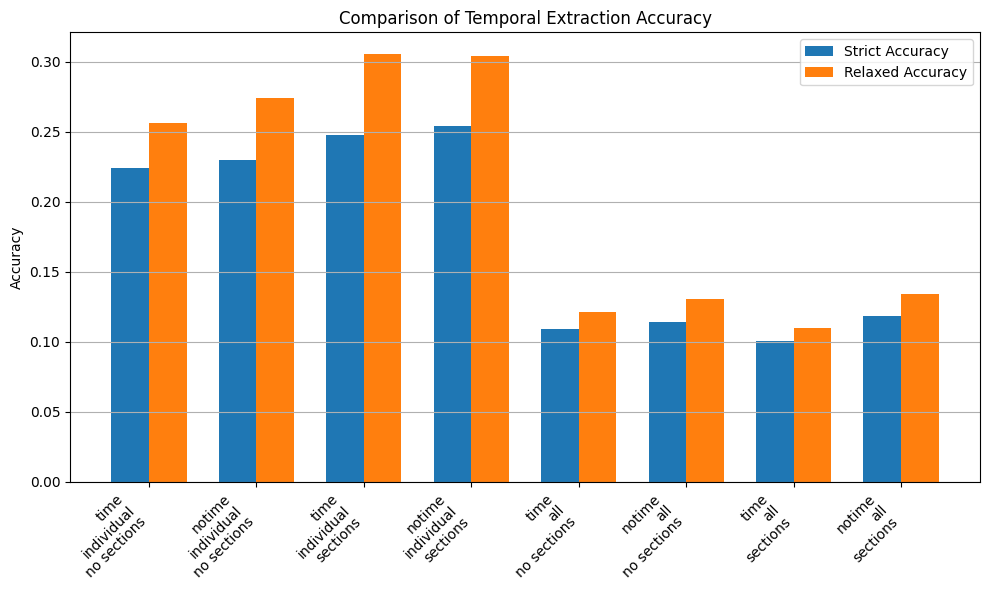

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the data
data = [
    ("time", "individual", False, 0.2242, 0.2561),
    ("notime", "individual", False, 0.2302, 0.2743),
    ("time", "individual", True, 0.2478, 0.3059),
    ("notime", "individual", True, 0.2542, 0.3045),
    ("time", "all", False, 0.1092, 0.1211),
    ("notime", "all", False, 0.1143, 0.1304),
    ("time", "all", True, 0.1003, 0.1102),
    ("notime", "all", True, 0.1186, 0.1342),
]

# Create DataFrame
df = pd.DataFrame(data, columns=["Time_Expression", "Query_Type", "Sections_Provided", "Strict_Accuracy", "Relaxed_Accuracy"])

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot grouped bars
bar_width = 0.35
x = range(len(df))
ax.bar([i - bar_width/2 for i in x], df["Strict_Accuracy"], width=bar_width, label="Strict Accuracy")
ax.bar([i + bar_width/2 for i in x], df["Relaxed_Accuracy"], width=bar_width, label="Relaxed Accuracy")

# Annotate x-axis
labels = [f"{row['Time_Expression']}\n{row['Query_Type']}\n{'sections' if row['Sections_Provided'] else 'no sections'}" for _, row in df.iterrows()]
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')

# Set labels and legend
ax.set_ylabel("Accuracy")
ax.set_title("Comparison of Temporal Extraction Accuracy")
ax.legend()

plt.tight_layout()
plt.grid(axis='y')
plt.show()
